In [1]:
# general
import subprocess
import calendar
from geopy.geocoders import Nominatim

# df and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# machine learning
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/strava_all_activities.csv')
print('Dataframe Shape:', df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataframe Shape: (547, 61)


,Unnamed: 0,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,...,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,workout_type.1,elev_high.1,elev_low.1,average_watts,kilojoules,device_watts
0,0.0,2.0,Corrida da tarde,6380.9,1987.0,1987.0,42.6,Run,Run,0.0,...,1.0,a11543087363,x~|vB~|zfGe@bASp@sAnCwAdDq@~@Oh@Qb@_ApAg@fAW\]...,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,Corrida da tarde,7131.2,1986.0,2020.0,45.3,Run,Run,3.0,...,1.0,a11520849184,vy|vBre{fGW^Yx@Ub@g@r@{@nB}@zAy@bBYVk@PkBPmA`@...,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,2.0,8ª Volta da Mata do Limoeiro,7806.5,2551.0,2562.0,168.8,Run,TrailRun,1.0,...,1.0,a11451445814,rxpvBtabhGFGBMl@Yn@{ATs@PORGb@DLHPTf@nANFJEFG@...,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,2.0,Double do Limoeiro 17k,16132.7,5373.0,5425.0,337.1,Run,TrailRun,1.0,...,1.0,a11442802792,nxpvBrcbhGg@HKRU~AJxBo@hADd@t@jAd@hBS|ADv@a@~@...,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,2.0,Corrida ao entardecer,4725.1,1557.0,1564.0,18.8,Run,Run,0.0,...,1.0,a11427848033,~}|vB`}zfGNMh@aAn@i@dDcB~BsAd@m@`@[Z_@x@i@x@o@...,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
null_df = [[col, df[col].isnull().sum()] for col in df.columns]
print('Null Data:', df.isnull().sum().sum())
list(filter(lambda x: x[1]>0, null_df))

Null Data: 5904


[['Unnamed: 0', 2],
 ['resource_state', 2],
 ['name', 2],
 ['distance', 2],
 ['moving_time', 2],
 ['elapsed_time', 2],
 ['total_elevation_gain', 2],
 ['type', 2],
 ['sport_type', 2],
 ['workout_type', 415],
 ['id', 2],
 ['start_date', 2],
 ['start_date_local', 2],
 ['timezone', 2],
 ['utc_offset', 2],
 ['location_city', 547],
 ['location_state', 547],
 ['location_country', 2],
 ['achievement_count', 2],
 ['kudos_count', 2],
 ['comment_count', 2],
 ['athlete_count', 2],
 ['photo_count', 2],
 ['trainer', 2],
 ['commute', 2],
 ['manual', 2],
 ['private', 2],
 ['visibility', 2],
 ['flagged', 2],
 ['gear_id', 290],
 ['start_latlng', 2],
 ['end_latlng', 2],
 ['average_speed', 2],
 ['max_speed', 2],
 ['average_cadence', 172],
 ['has_heartrate', 2],
 ['average_heartrate', 96],
 ['max_heartrate', 96],
 ['heartrate_opt_out', 2],
 ['display_hide_heartrate_option', 2],
 ['elev_high', 223],
 ['elev_low', 223],
 ['upload_id', 2],
 ['upload_id_str', 2],
 ['external_id', 2],
 ['from_accepted_tag', 2],

In [3]:
# Selecionando as colunas desejadas
selected_columns = ['distance', 'moving_time', 'elapsed_time',
                    'total_elevation_gain', 'type','sport_type', 'id', 'start_date',
                    'start_date_local','location_country', 'achievement_count', 'kudos_count',
                    'comment_count','athlete_count', 'start_latlng',
                    'end_latlng', 'average_speed', 'max_speed', 'average_cadence',
                    'average_heartrate', 'max_heartrate', 'elev_high','elev_low',
                    'upload_id', 'external_id', 'pr_count', 'map.summary_polyline']

# Selecionando as colunas no DataFrame
df = df[selected_columns]

# Convertendo a coluna 'start_date_local' para datetime
# df.loc[:, 'start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')
df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')

# Verificando valores nulos após a conversão
nulos = df['start_date_local'].isnull().sum()
if nulos > 0:
    print(f"Existem {nulos} valores nulos em 'start_date_local' após a conversão.")

# Removendo linhas com valores nulos em 'start_date_local'
df = df.dropna(subset=['start_date_local'])

# Ordenando o DataFrame pela coluna 'start_date_local'
df = df.sort_values(by='start_date_local')

# Adicionando novas colunas ao DataFrame
df.loc[:, 'weekday'] = df['start_date_local'].dt.weekday
df.loc[:, 'start_time'] = df['start_date_local'].dt.time.astype(str)
df.loc[:, 'start_date'] = df['start_date_local'].dt.date
# df['weekday'] = df['start_date_local'].map(lambda x: x.weekday)
# df['start_time'] = df['start_date_local'].dt.time
# df['start_time'] = df['start_time'].astype(str)
# df['start_date'] = df['start_date_local'].dt.date

# Removendo a coluna 'start_date_local'
df = df.drop('start_date_local', axis=1)

# Exibindo as primeiras linhas do DataFrame
df.head()

Existem 2 valores nulos em 'start_date_local' após a conversão.


<ipython-input-3-79c1e29d2ea2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')


,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time
546,1116.8,740.0,779.0,0.0,Run,Run,7.831961e+09,2015-04-05,Brazil,0.0,...,NaN,NaN,744.2,694.6,8.367949e+09,garmin_ping_239636712697,0.0,bo~vB~_wfGQGc@BOAa@Qk@[S_@O?_@OIO[[YS_@OKM_A]_...,6,13:35:15
545,5469.6,2333.0,2412.0,46.6,Run,Run,7.831961e+09,2016-01-05,Brazil,3.0,...,NaN,NaN,772.4,736.4,8.367950e+09,garmin_ping_239636713326,1.0,nz~vBn{vfGv@IfA?NCPFd@BNB\Pr@L\TdBf@xCdA`@Jd@F...,1,07:58:09
544,12793.5,6739.0,7469.0,228.5,Run,Run,7.831961e+09,2016-09-18,Brazil,0.0,...,NaN,NaN,780.6,689.8,8.367949e+09,garmin_ping_239636711551,0.0,nh}vBt~ufG`@HDb@Z@DPGPe@ND`@]JCNa@NS^mC}@W@o@o...,6,18:37:16
543,5398.4,1818.0,3257.0,21.6,Run,Run,7.831961e+09,2017-01-24,Brazil,0.0,...,NaN,NaN,765.7,756.4,8.367949e+09,garmin_ping_239636710177,0.0,`}xvBtxyfGPETRJb@X`@RfAHdADNTfCJb@AVFb@b_@xL^O...,1,19:28:39
542,3850.1,1261.0,1414.0,2.5,Run,Run,7.831961e+09,2017-02-05,Brazil,0.0,...,NaN,NaN,10.0,7.4,8.367949e+09,garmin_ping_239636709988,0.0,dpxqClh_{GzEqVESYYASIQOIKe@BQMKGQESASIOMMMe@IO...,6,07:48:43


In [4]:
import time

df = df.drop(df[(df.distance < 1) & (df.type == 'Run')].index)
df = df.drop(df[(df.distance < 1) & (df.type == 'Ride')].index)
df = df.drop(df[df.average_speed > 30].index)
df = df.reset_index(drop=True)

geolocator = Nominatim(user_agent="strava_exploration_data")

df['elev_high'] = df['elev_high'].fillna(value=0)
df['elev_low'] = df['elev_low'].fillna(value=0)
df['upload_id'] = df['upload_id'].fillna(value='unknown')
df['external_id'] = df['external_id'].fillna(value='unknown')
df['map.summary_polyline'] = df['map.summary_polyline'].fillna(value='unknown')
df['average_cadence'] = df['average_cadence'].fillna(value=df['average_cadence'].mean())
df['average_heartrate'] = df['average_heartrate'].fillna(value=df['average_heartrate'].mean())
df['max_heartrate'] = df['max_heartrate'].fillna(value=df['max_heartrate'].mean())

df['moving_time_minutes'] = round(df['moving_time']/60, 2)
df['distance_km'] = round(df['distance'] / 1000, 2)
df['pace'] = df['moving_time_minutes'] / df['distance_km']
df['avg_speed_kmh'] = round(60/df['pace'], 2)
df['max_speed_kmh'] = round(df['max_speed']*3.6, 2)
df['elev'] = df['elev_high'] - df['elev_low']
df['year']= df['start_date'].map(lambda x: x.year)

def get_city_state_from_value(value):
    time.sleep(1.2)
    value = str(value).replace('[','').replace(']','').split(',')
    try:
        if value != ['']:
            location = geolocator.reverse(', '.join(value))
            result = f'{location[0].split(",")[1]}, {location[0].split(",")[4]}'
        else:
            result = 'unknown'
        return result
    except:
        return 'unknown'

df['location'] = df['start_latlng'].map(get_city_state_from_value)

df['pace_sub_5'] = np.where(df['pace']<=5, True, False)
df.head()

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,start_time,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,location,pace_sub_5
0,1116.8,740.0,779.0,0.0,Run,Run,7.831961e+09,2015-04-05,Brazil,0.0,...,13:35:15,12.33,1.12,11.008929,5.45,7.84,49.6,2015,"Gabiroba, Região Geográfica Intermediária de...",False
1,5469.6,2333.0,2412.0,46.6,Run,Run,7.831961e+09,2016-01-05,Brazil,3.0,...,07:58:09,38.88,5.47,7.107861,8.44,15.56,36.0,2016,"Gabiroba, Região Geográfica Intermediária de...",False
2,12793.5,6739.0,7469.0,228.5,Run,Run,7.831961e+09,2016-09-18,Brazil,0.0,...,18:37:16,112.32,12.79,8.781861,6.83,36.81,90.8,2016,"Gabiroba, Região Geográfica Intermediária de...",False
3,5398.4,1818.0,3257.0,21.6,Run,Run,7.831961e+09,2017-01-24,Brazil,0.0,...,19:28:39,30.30,5.40,5.611111,10.69,15.08,9.3,2017,"Esplanada da Estação, Região Geográfica Inte...",False
4,3850.1,1261.0,1414.0,2.5,Run,Run,7.831961e+09,2017-02-05,Brazil,0.0,...,07:48:43,21.02,3.85,5.459740,10.99,87.37,2.6,2017,"30, Vila Caiçara",False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              534 non-null    float64
 1   moving_time           534 non-null    float64
 2   elapsed_time          534 non-null    float64
 3   total_elevation_gain  534 non-null    float64
 4   type                  534 non-null    object 
 5   sport_type            534 non-null    object 
 6   id                    534 non-null    float64
 7   start_date            534 non-null    object 
 8   location_country      534 non-null    object 
 9   achievement_count     534 non-null    float64
 10  kudos_count           534 non-null    float64
 11  comment_count         534 non-null    float64
 12  athlete_count         534 non-null    float64
 13  start_latlng          534 non-null    object 
 14  end_latlng            534 non-null    object 
 15  average_speed         5

In [6]:
df.describe()

,distance,moving_time,elapsed_time,total_elevation_gain,id,achievement_count,kudos_count,comment_count,athlete_count,average_speed,...,upload_id,pr_count,weekday,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year
count,534.000000,534.000000,534.000000,534.000000,5.340000e+02,534.000000,534.000000,534.000000,534.000000,534.000000,...,5.340000e+02,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000
mean,6006.660674,2788.436330,3091.597378,72.895506,8.751698e+09,0.799625,1.808989,0.035581,1.646067,2.312163,...,9.368089e+09,0.264045,2.951311,46.474213,6.006592,inf,8.331742,13.135712,28.311985,2022.215356
std,6149.730546,2725.730668,3287.707438,210.525520,1.058345e+09,2.675565,2.165964,0.246263,4.974627,1.418946,...,1.137463e+09,1.325015,1.899311,45.428999,6.149880,NaN,5.099801,8.300351,85.401692,1.435436
min,0.000000,14.000000,290.000000,0.000000,7.097170e+09,0.000000,0.000000,0.000000,1.000000,0.000000,...,7.555444e+09,0.000000,0.000000,0.230000,0.000000,1.769231,0.000000,0.000000,0.000000,2015.000000
25%,1170.500000,1803.000000,1988.500000,2.525000,7.831959e+09,0.000000,0.000000,0.000000,1.000000,1.613500,...,8.367947e+09,0.000000,1.000000,30.050000,1.172500,5.281887,5.800000,9.752500,0.000000,2022.000000
50%,5284.650000,2482.500000,2615.500000,38.800000,8.418208e+09,0.000000,1.000000,0.000000,1.000000,2.621000,...,9.030544e+09,0.000000,3.000000,41.375000,5.285000,6.344888,9.455000,14.355000,18.800000,2023.000000
75%,8051.950000,3145.500000,3418.250000,65.950000,9.452190e+09,0.000000,3.000000,0.000000,1.000000,3.155250,...,1.013746e+10,0.000000,5.000000,52.422500,8.052500,10.346655,11.360000,17.250000,42.100000,2023.000000
max,69515.200000,43894.000000,55879.000000,3362.800000,1.154309e+10,28.000000,10.000000,2.000000,96.000000,9.619000,...,1.232130e+10,22.000000,6.000000,731.570000,69.520000,inf,33.910000,87.370000,1865.400000,2024.000000


In [7]:
df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,524,525,526,527,528,529,530,531,532,533
distance,1116.8,5469.6,12793.5,5398.4,3850.1,442.9,499.2,6051.5,4168.2,7859.5,...,0.0,11003.2,0.0,8017.7,12365.1,4725.1,16132.7,7806.5,7131.2,6380.9
moving_time,740.0,2333.0,6739.0,1818.0,1261.0,275.0,103.0,2862.0,2602.0,3604.0,...,924.0,3309.0,1301.0,2404.0,3605.0,1557.0,5373.0,2551.0,1986.0,1987.0
elapsed_time,779.0,2412.0,7469.0,3257.0,1414.0,290.0,631.0,3167.0,2954.0,3756.0,...,924.0,3314.0,1301.0,2404.0,3605.0,1564.0,5425.0,2562.0,2020.0,1987.0
total_elevation_gain,0.0,46.6,228.5,21.6,2.5,0.0,0.0,85.5,44.1,114.5,...,0.0,66.3,0.0,63.2,172.6,18.8,337.1,168.8,45.3,42.6
type,Run,Run,Run,Run,Run,Run,Run,Run,Run,Run,...,Workout,Run,Workout,Run,Run,Run,Run,Run,Run,Run
sport_type,Run,Run,Run,Run,Run,Run,Run,Run,Run,Run,...,Workout,Run,Workout,Run,Run,Run,TrailRun,TrailRun,Run,Run
id,7831961131.0,7831961196.0,7831961097.0,7831960994.0,7831961000.0,7831960933.0,7831960917.0,7831960843.0,7831960857.0,7831960858.0,...,11342081213.0,11364493471.0,11364717984.0,11395959325.0,11407086282.0,11427848033.0,11442802792.0,11451445814.0,11520849184.0,11543087363.0
start_date,2015-04-05,2016-01-05,2016-09-18,2017-01-24,2017-02-05,2017-02-05,2017-02-05,2018-11-03,2018-11-12,2018-11-15,...,2024-05-05,2024-05-08,2024-05-08,2024-05-12,2024-05-14,2024-05-16,2024-05-18,2024-05-19,2024-05-27,2024-05-31
location_country,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,...,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil
achievement_count,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0


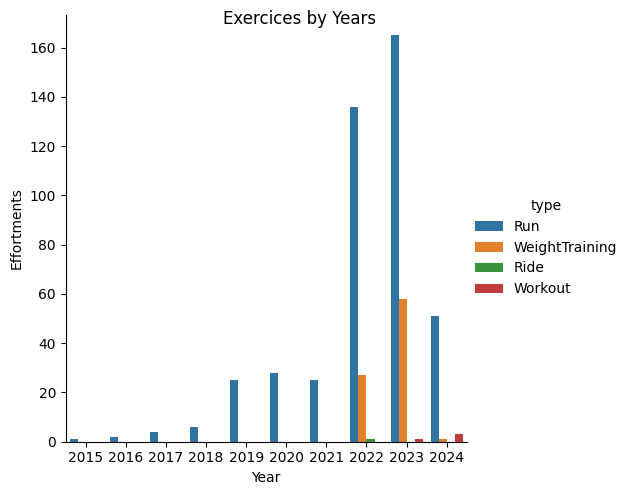

In [8]:
fig = sns.catplot(x='year', hue='type', data=df, kind='count')
fig.fig.suptitle('Exercices by Years')
fig.set_xlabels('Year')
fig.set_ylabels('Effortments')
fig

Text(0.5, 1.0, 'Exercice Time vs Elevation')

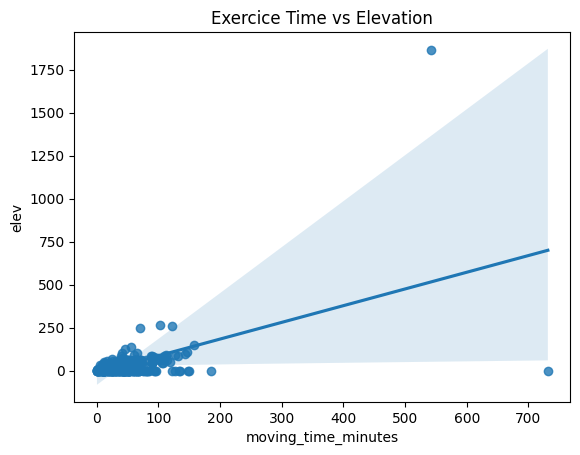

In [9]:
runs = df.loc[df['type'] == 'Run']
sns.regplot(x='moving_time_minutes', y = 'elev', data=runs).set_title("Exercice Time vs Elevation")

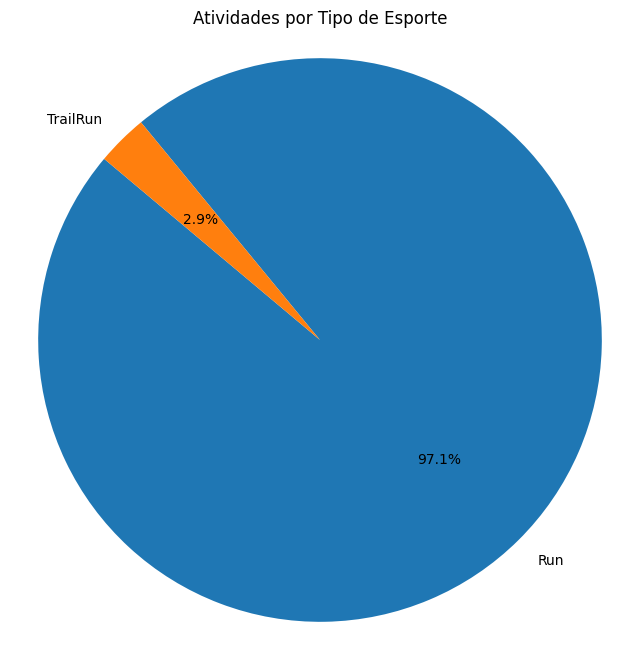

In [30]:
import matplotlib.pyplot as plt

# Agrupar as atividades por tipo de esporte e contar o número de atividades em cada categoria
atividades_por_esporte = runs['sport_type'].value_counts()

# Criar o gráfico de setores
plt.figure(figsize=(8, 8))
plt.pie(atividades_por_esporte, labels=atividades_por_esporte.index, autopct='%1.1f%%', startangle=140)
plt.title('Atividades por Tipo de Esporte')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

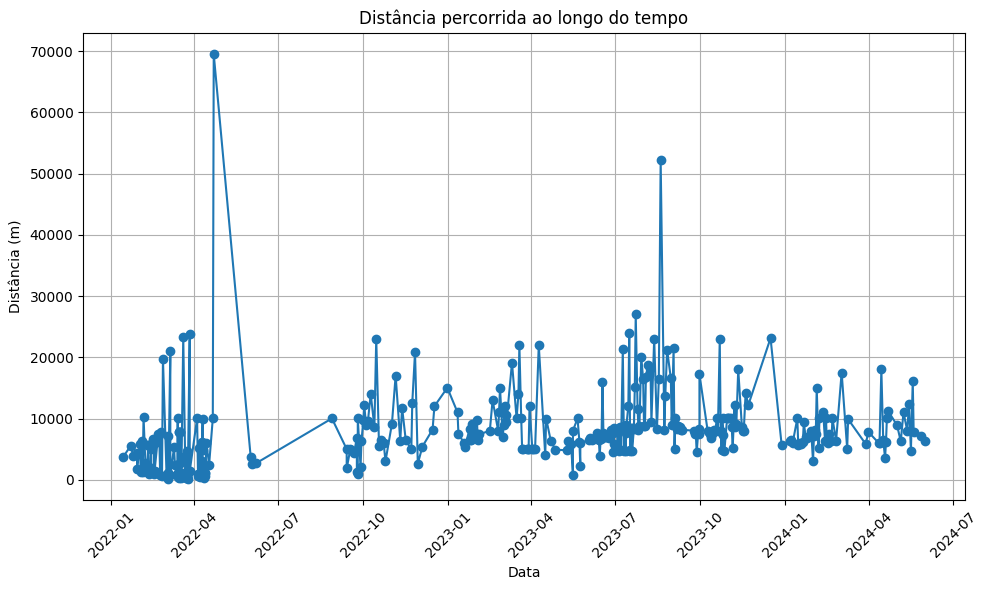

In [27]:
# Supondo que você já carregou seus dados em um DataFrame chamado 'atividades'
# Certifique-se de que a coluna de data está no formato datetime
# runs['data'] = pd.to_datetime(atividades['data'])

# Converta a coluna 'start_date' para o formato datetime, caso ainda não esteja
runs['start_date'] = pd.to_datetime(runs['start_date'])

# Filtre as atividades a partir de janeiro de 2022
runs_2022 = runs[runs['start_date'] >= '2022-01-01']

# Ordenar as atividades por data, se necessário
runs_2022 = runs_2022.sort_values(by='start_date')

# Plotar o gráfico de linhas
plt.figure(figsize=(10, 6))
plt.plot(runs_2022['start_date'], runs_2022['distance'], marker='o', linestyle='-')
plt.title('Distância percorrida ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Distância (m)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para facilitar a leitura
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distance vs Elevation')

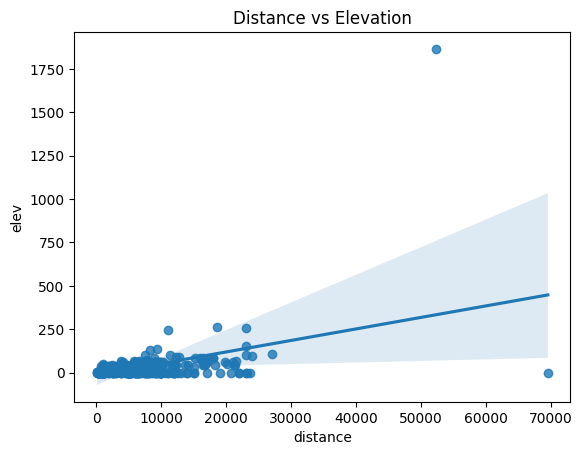

In [10]:
sns.regplot(x='distance', y = 'elev', data=runs).set_title("Distance vs Elevation")

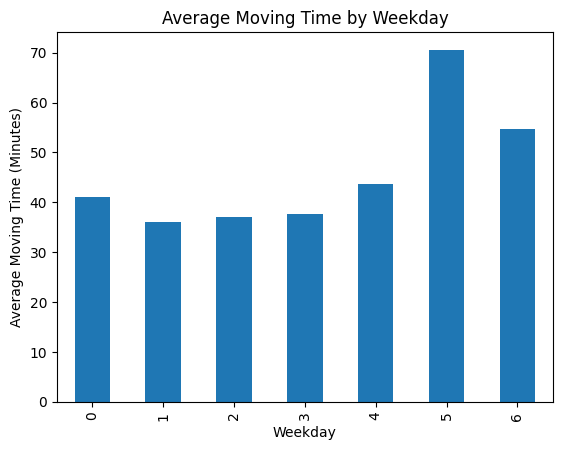

In [11]:
# Selecionar apenas as colunas necessárias
df_filtered = runs[['weekday', 'moving_time_minutes']].copy()

# Garantir que 'weekday' é do tipo inteiro
df_filtered.loc[:, 'weekday'] = df_filtered['weekday'].astype(int)

# Garantir que 'moving_time_minutes' é do tipo float
df_filtered.loc[:, 'moving_time_minutes'] = df_filtered['moving_time_minutes'].astype(float)

# Agrupando por 'weekday' e calculando a média de 'moving_time_minutes'
grouped_runs = df_filtered.groupby('weekday').mean()['moving_time_minutes']

# Plotando o gráfico de barras
grouped_runs.plot.bar()
plt.xlabel('Weekday')
plt.ylabel('Average Moving Time (Minutes)')
plt.title('Average Moving Time by Weekday')
plt.show()

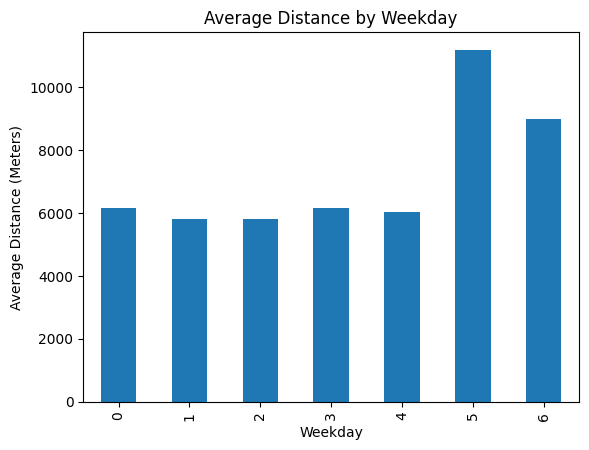

In [12]:
# Selecionar apenas as colunas necessárias
df_filtered_distance = runs[['weekday', 'distance']].copy()

# Garantir que 'weekday' é do tipo inteiro
df_filtered_distance.loc[:, 'weekday'] = df_filtered_distance['weekday'].astype(int)

# Garantir que 'distance' é do tipo float
df_filtered_distance.loc[:, 'distance'] = df_filtered_distance['distance'].astype(float)

# Agrupando por 'weekday' e calculando a média de 'distance'
grouped_runs = df_filtered_distance.groupby('weekday').mean()['distance']

# Plotando o gráfico de barras
grouped_runs.plot.bar()
plt.xlabel('Weekday')
plt.ylabel('Average Distance (Meters)')
plt.title('Average Distance by Weekday')
plt.show()

Text(0.5, 1.0, 'Average Speed vs Moving Time')

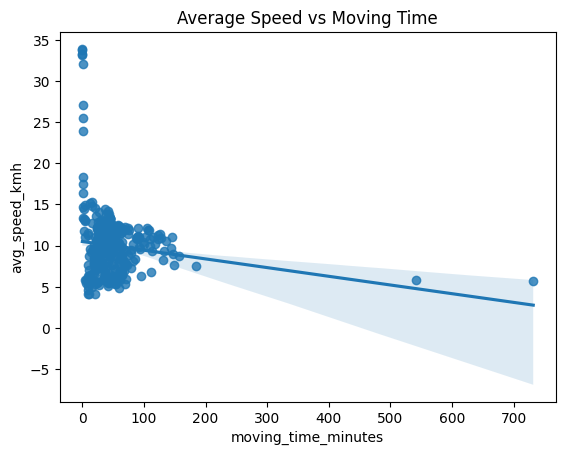

In [13]:
sns.regplot(x='moving_time_minutes', y = 'avg_speed_kmh', data=runs).set_title("Average Speed vs Moving Time")

Text(0.5, 1.0, 'Average Speed vs Distance')

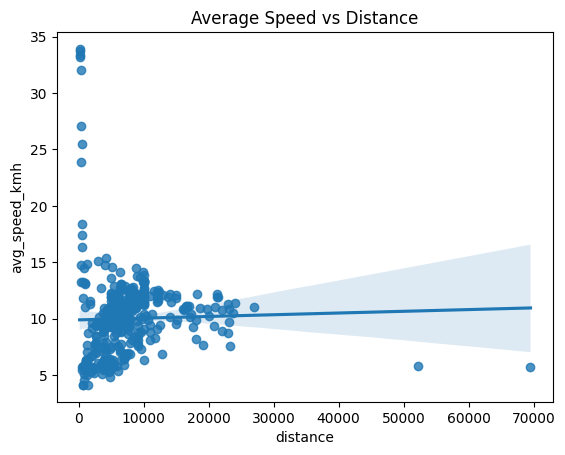

In [14]:
sns.regplot(x='distance', y = 'avg_speed_kmh', data=runs).set_title("Average Speed vs Distance")

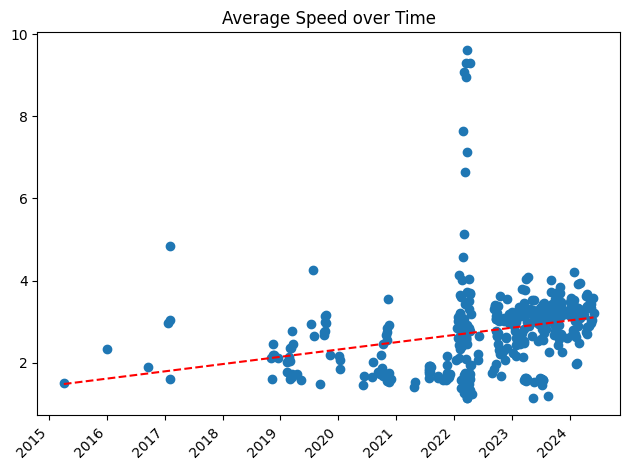

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(runs.start_date)
y = np.asarray(runs.average_speed)

ax1.plot_date(x, y)
ax1.set_title('Average Speed over Time')


x2 = mdates.date2num(x)
z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

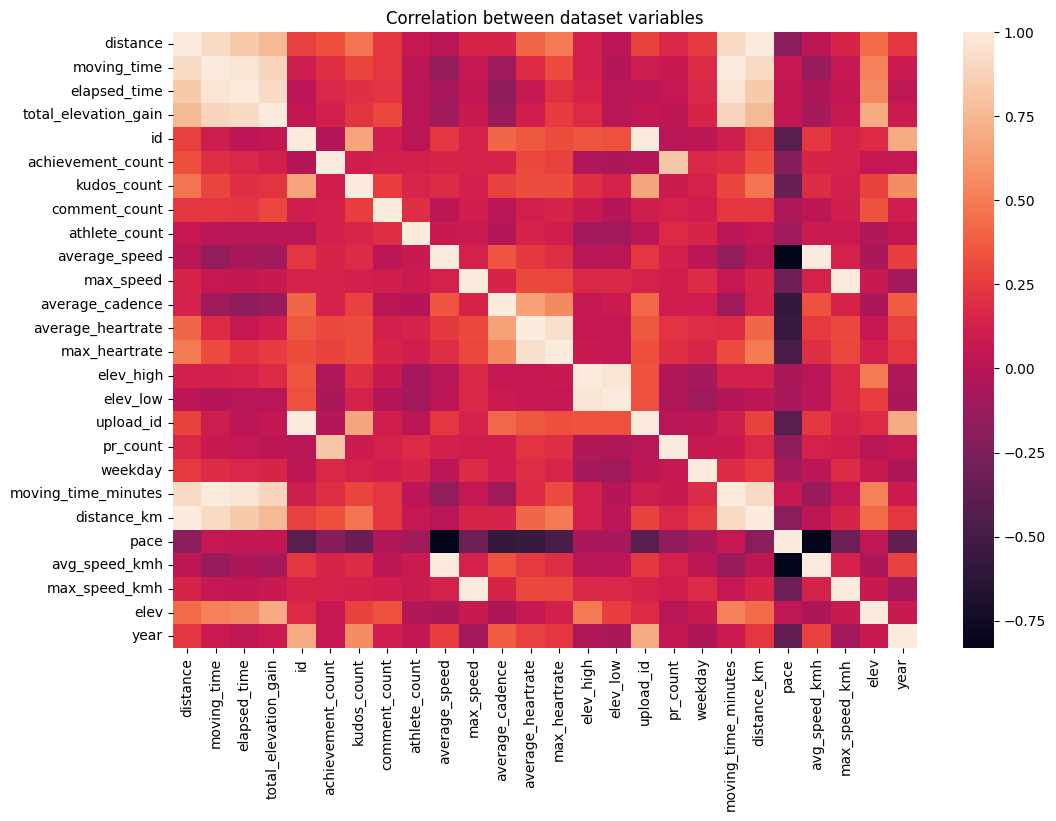

In [16]:
# Selecionando apenas as colunas numéricas
numeric_cols = runs.select_dtypes(include=['number'])

# Calculando a matriz de correlação
corr = numeric_cols.corr()
# corr = runs.corr()

# Plotando o heatmap
plt.figure(figsize = (12,8))
sns.heatmap(corr, fmt=".2f");
plt.title('Correlation between dataset variables')
plt.show()

In [17]:
runs = runs.sample(frac=1).reset_index(drop=True)
categorical_cols = [col for col in runs.columns if runs[col].dtypes == 'O']
useless_vars = ['id', 'achievement_count', 'kudos_count', 'comment_count', 'pr_count']
tweak_runs = runs.drop(categorical_cols+useless_vars, axis=1)
tweak_runs

,distance,moving_time,elapsed_time,total_elevation_gain,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,...,upload_id,weekday,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,pace_sub_5
0,1116.8,740.0,779.0,0.0,1.0,1.509,2.179,77.879245,139.661364,163.572727,...,8.367949e+09,6,12.33,1.12,11.008929,5.45,7.84,49.6,2015,False
1,4617.8,2911.0,3012.0,34.9,2.0,1.586,2.460,62.600000,87.300000,118.000000,...,1.017103e+10,2,48.52,4.62,10.502165,5.71,8.86,37.3,2023,False
2,5482.4,3399.0,4095.0,57.4,1.0,1.613,3.515,77.879245,139.661364,163.572727,...,8.367949e+09,0,56.65,5.48,10.337591,5.80,12.65,26.2,2019,False
3,8607.8,3714.0,3714.0,0.0,1.0,2.318,4.005,82.100000,163.400000,187.000000,...,8.511225e+09,3,61.90,8.61,7.189315,8.35,14.42,0.0,2022,False
4,7577.8,2405.0,2431.0,199.8,5.0,3.117,6.440,83.600000,169.100000,187.000000,...,9.965513e+09,6,40.08,7.58,5.287599,11.35,23.18,102.3,2023,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,9160.6,4070.0,4070.0,0.0,1.0,2.251,3.413,78.400000,152.300000,187.000000,...,8.620893e+09,1,67.83,9.16,7.405022,8.10,12.29,0.0,2022,False
439,6607.9,2410.0,2414.0,173.6,1.0,2.742,5.015,83.200000,171.200000,194.000000,...,8.351036e+09,1,40.17,6.61,6.077156,9.87,18.05,66.5,2022,False
440,11011.6,4195.0,4322.0,410.9,1.0,2.625,5.280,78.100000,171.600000,206.000000,...,1.148523e+10,6,69.92,11.01,6.350590,9.45,19.01,246.5,2024,False
441,8007.9,2553.0,2553.0,65.0,1.0,3.137,4.688,80.300000,168.700000,200.000000,...,9.249881e+09,4,42.55,8.01,5.312110,11.29,16.88,0.0,2023,False


In [18]:
y = tweak_runs['pace']
X = tweak_runs.drop('pace', axis=1)

best_features = SelectKBest(chi2, k=7).fit_transform(X, y.astype(int))
best_features

array([[1.11680000e+03, 7.40000000e+02, 7.79000000e+02, ...,
        7.44200000e+02, 6.94600000e+02, 8.36794944e+09],
       [4.61780000e+03, 2.91100000e+03, 3.01200000e+03, ...,
        7.34700000e+02, 6.97400000e+02, 1.01710331e+10],
       [5.48240000e+03, 3.39900000e+03, 4.09500000e+03, ...,
        7.44500000e+02, 7.18300000e+02, 8.36794873e+09],
       ...,
       [1.10116000e+04, 4.19500000e+03, 4.32200000e+03, ...,
        1.09860000e+03, 8.52100000e+02, 1.14852276e+10],
       [8.00790000e+03, 2.55300000e+03, 2.55300000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 9.24988067e+09],
       [8.55380000e+03, 2.70800000e+03, 2.70800000e+03, ...,
        7.35400000e+02, 6.92800000e+02, 1.09047586e+10]])

In [19]:
def get_best_rfe_features(X,y, model):
    rfe = RFE(model, step=0.05).fit(X, y)
    selected_features = [i for i, j in zip(X.columns, rfe.support_) if j]
    return selected_features

y = tweak_runs['pace']
X = tweak_runs.drop('pace', axis=1)

encoded_y = preprocessing.LabelEncoder().fit_transform(y)
model = LinearRegression()
linear_feats = get_best_rfe_features(X, encoded_y, model)

In [20]:
y = tweak_runs['pace_sub_5']
X = tweak_runs.drop('pace_sub_5', axis=1)

model = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000)
class_feats = get_best_rfe_features(X, y, model)

In [21]:
# Selecionar apenas as colunas numéricas
X_numeric = X.select_dtypes(include=['number'])

# Aplicar KMeans nas colunas numéricas
model = KMeans(n_clusters=4, n_init=10).fit(X_numeric)

# Selecionar apenas as colunas numéricas
numeric_columns = runs.select_dtypes(include=['number']).columns

# Copiar apenas as colunas numéricas para clustering_runs
clustering_runs = runs[numeric_columns].copy()

# Adicionar os rótulos dos clusters
clustering_runs['Cluster'] = model.labels_

# Contar o número de instâncias em cada cluster
cluster_counts = clustering_runs['Cluster'].value_counts()

# Visualizar os dados médios em cada cluster
# cluster_means =
clustering_runs.groupby('Cluster').mean()

,distance,moving_time,elapsed_time,total_elevation_gain,id,achievement_count,kudos_count,comment_count,athlete_count,average_speed,...,upload_id,pr_count,weekday,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year
Cluster,,,,,,,,,,,,,,,,,,,,,
0,5218.303982,2307.420354,2894.238938,70.580088,7.842047e+09,0.964602,0.199115,0.008850,1.384956,2.557504,...,8.379621e+09,0.292035,3.119469,38.457257,5.218186,7.601244,9.208319,15.039823,20.319469,2021.030973
1,8320.705660,2697.037736,2781.641509,94.632075,1.091008e+10,0.754717,3.452830,0.094340,1.773585,3.168566,...,1.166332e+10,0.245283,3.547170,44.951509,8.320189,5.349220,11.438113,18.162642,49.705660,2023.962264
2,10343.962617,3586.654206,3735.504673,119.199065,9.704307e+09,0.934579,4.336449,0.065421,1.345794,3.002925,...,1.040310e+10,0.299065,2.831776,59.777850,10.344299,5.795454,10.830187,15.366822,67.615888,2023.000000
3,8306.500000,3000.298246,3042.701754,90.094737,8.777846e+09,1.210526,3.035088,0.087719,4.157895,2.854807,...,9.418999e+09,0.526316,3.228070,50.004737,8.306316,6.268812,10.281228,15.403509,10.414035,2022.982456


In [22]:
clustering_runs.groupby('Cluster').std()

,distance,moving_time,elapsed_time,total_elevation_gain,id,achievement_count,kudos_count,comment_count,athlete_count,average_speed,...,upload_id,pr_count,weekday,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year
Cluster,,,,,,,,,,,,,,,,,,,,,
0,5995.572434,3215.611944,3902.742784,211.092193,1.161019e+08,3.538811,0.632595,0.133038,2.958610,1.364376,...,1.300724e+08,1.759704,1.904118,53.593688,5.995757,2.504488,4.888376,7.636905,22.014861,1.440344
1,3800.364470,1431.707130,1488.579836,95.278898,3.314066e+08,1.930580,2.034000,0.404976,1.917947,0.418118,...,3.458958e+08,0.917892,1.947049,23.862216,3.799863,0.825236,1.506711,3.362667,37.423930,0.192380
2,6420.080985,3261.019238,4225.436113,326.775554,3.179081e+08,1.884750,2.114389,0.343979,1.221682,0.534742,...,3.349213e+08,0.803471,1.959428,54.350381,6.420458,1.533257,1.881573,2.895436,178.875627,0.000000
3,4216.676003,1658.907827,1685.976084,137.350565,2.608922e+08,2.505258,1.591999,0.342298,13.658840,0.650791,...,2.793644e+08,1.440551,1.870996,27.648934,4.216528,2.040023,2.345768,3.996341,18.379078,0.132453


In [23]:
clustering_runs[clustering_runs['Cluster'] == 2]

,distance,moving_time,elapsed_time,total_elevation_gain,id,achievement_count,kudos_count,comment_count,athlete_count,average_speed,...,pr_count,weekday,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,Cluster
1,4617.8,2911.0,3012.0,34.9,9.484006e+09,0.0,7.0,0.0,2.0,1.586,...,0.0,2,48.52,4.62,10.502165,5.71,8.86,37.3,2023,2
4,7577.8,2405.0,2431.0,199.8,9.289995e+09,0.0,5.0,2.0,5.0,3.117,...,0.0,6,40.08,7.58,5.287599,11.35,23.18,102.3,2023,2
7,4655.9,3186.0,3221.0,36.0,9.426885e+09,0.0,3.0,0.0,2.0,1.461,...,0.0,0,53.10,4.66,11.394850,5.27,12.27,37.6,2023,2
20,4615.9,2873.0,2905.0,35.7,9.439940e+09,0.0,6.0,0.0,2.0,1.607,...,0.0,2,47.88,4.62,10.363636,5.79,10.32,37.5,2023,2
27,7909.4,2522.0,2522.0,51.3,9.368321e+09,0.0,4.0,0.0,1.0,3.136,...,0.0,5,42.03,7.91,5.313527,11.29,13.54,42.3,2023,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,4592.8,2810.0,2830.0,35.2,9.353044e+09,0.0,3.0,0.0,2.0,1.634,...,0.0,2,46.83,4.59,10.202614,5.88,8.41,37.7,2023,2
432,8639.6,2524.0,2524.0,64.1,9.815316e+09,0.0,5.0,0.0,1.0,3.423,...,0.0,5,42.07,8.64,4.869213,12.32,16.13,42.2,2023,2
433,27015.2,8776.0,8804.0,372.5,9.506813e+09,3.0,8.0,0.0,1.0,3.078,...,0.0,6,146.27,27.02,5.413397,11.08,15.65,109.8,2023,2
437,22997.2,9447.0,9623.0,388.8,1.008363e+10,0.0,9.0,0.0,1.0,2.434,...,0.0,6,157.45,23.00,6.845652,8.76,13.42,151.1,2023,2


MSE: 0.85860214966807


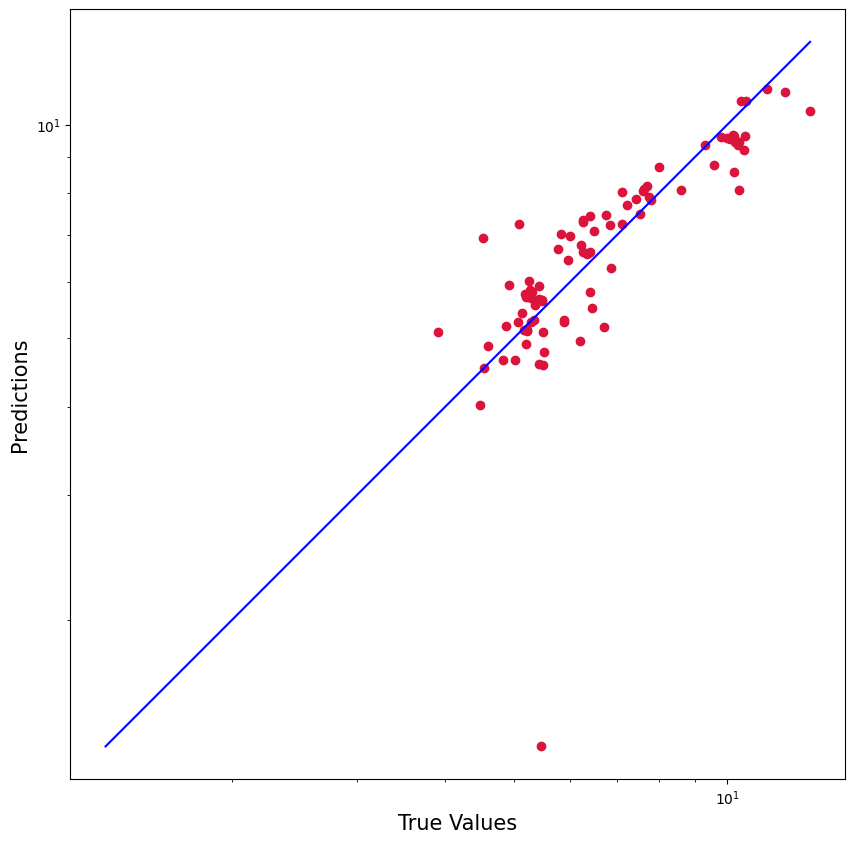

In [24]:
y = runs['pace']
X = runs[linear_feats]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print('MSE:', metrics.mean_squared_error(y_test, y_pred))

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [25]:
from datetime import datetime

# Suponha que você está prevendo dados para o dia 1º de janeiro de 2025
predicted_date = datetime(2025, 1, 1)

# Obtenha o dia da semana para a data prevista (segunda-feira é 0, domingo é 6)
predicted_weekday = predicted_date.weekday()

# Crie um DataFrame com os dados de previsão
prediction_data = pd.DataFrame(data={
    'moving_time': 1488,
    'average_speed': 4.0,
    'max_speed': 5.6,
    'average_cadence': 84.0,
    'moving_time_minutes': 24.8,
    'distance_km': 5.0,
    'avg_speed_kmh': 14.4,
    'max_speed_kmh': 20.16 ,
    'year': 2025,
    'pace_sub_5': True,
    'weekday': predicted_weekday  # Incluindo o dia da semana previsto
}, index=[0])

# # Faça a previsão usando o modelo
# prediction = model.predict(prediction_data)

# model.predict(
#     pd.DataFrame(data={
#         'moving_time': 1488,
#         'average_speed': 4.0,
#         'max_speed': 5.6,
#         'average_cadence': 84.0,
#         'moving_time_minutes': 24.8,
#         'distance_km': 5.0,
#         'avg_speed_kmh': 14.4,
#         'max_speed_kmh': 20.16 ,
#         'year': 2022,
#         'pace_sub_5': True},
#     index=[0]
#     )
# )

Accuracy: 0.8202247191011236


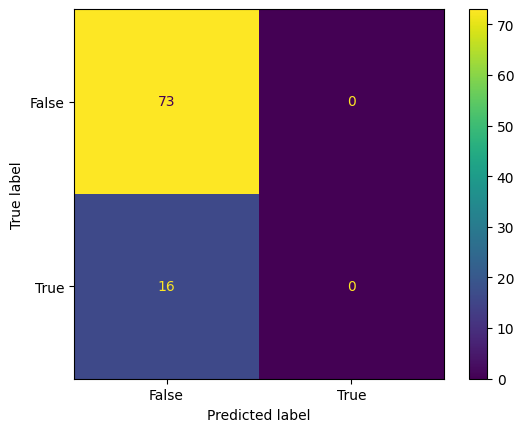

In [26]:
y = runs['pace_sub_5']
X = runs[class_feats]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = SGDClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)

disp.plot()
plt.show()

In [28]:
import plotly.express as px

# Filtrar apenas as linhas em que o valor da coluna 'start_latlng' não é nulo
runs_com_latlng = runs[runs['start_latlng'].notna()]
runs_com_latlng = runs_com_latlng[runs_com_latlng['start_latlng'] != '[]']

# 1. Selecione os dados relevantes
atividades = runs_com_latlng[['start_latlng', 'avg_speed_kmh']]

# 1. Extrair informações relevantes dos dados
latitude_longitude = runs_com_latlng['start_latlng']

# Verificar se os dados foram extraídos corretamente
# print(latitude_longitude[:5])  # Verificar as primeiras 5 entradas

# 2. Corrigir o formato das coordenadas de latitude e longitude
latitude = []
longitude = []

for coord in latitude_longitude:
    value = str(coord).replace('[','').replace(']','').split(',')
    if isinstance(value, list) and len(value) == 2:  # Verificar se é uma lista com duas coordenadas
        latitude.append(float(value[0]))
        longitude.append(float(value[1]))


# 3. Divida as coordenadas de latitude e longitude
atividades['latitude'] = latitude
atividades['longitude'] = longitude

# 4. Agrupe as atividades por região (latitude e longitude aproximadas)
# Você pode definir suas próprias regras para agrupar as atividades em regiões
# Por exemplo, você pode agrupar atividades em quadrantes de latitude e longitude
atividades['latitude_bin'] = pd.cut(atividades['latitude'], bins=5)
atividades['longitude_bin'] = pd.cut(atividades['longitude'], bins=5)

# Converta as colunas categóricas latitude_bin e longitude_bin em valores numéricos
atividades['latitude_bin'] = pd.factorize(atividades['latitude_bin'])[0]
atividades['longitude_bin'] = pd.factorize(atividades['longitude_bin'])[0]

# 5. Calcule a velocidade média para cada região
velocidade_media_por_regiao = atividades.groupby(['latitude_bin', 'longitude_bin'])['avg_speed_kmh'].mean().reset_index()

# Remover valores NaN da coluna 'avg_speed_kmh'
velocidade_media_por_regiao = velocidade_media_por_regiao.dropna(subset=['avg_speed_kmh'])

# 6. Crie um gráfico de dispersão
fig = px.scatter_mapbox(velocidade_media_por_regiao,
                         lat='latitude',
                         lon='longitude',
                         color='avg_speed_kmh',
                         color_continuous_scale='Viridis',
                        #  size='avg_speed_kmh',
                        #  size_max=15,
                         zoom=3)

# 7. Personalize o layout do mapa
fig.update_layout(mapbox_style="open-street-map",
                  mapbox_zoom=3,
                  mapbox_center={"lat": -15, "lon": -50})

# 8. Exiba o gráfico
fig.show()

<ipython-input-28-dde6511f2f7c>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atividades['latitude'] = latitude
<ipython-input-28-dde6511f2f7c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atividades['longitude'] = longitude
<ipython-input-28-dde6511f2f7c>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

ValueError: Value of 'lat' is not the name of a column in 'data_frame'. Expected one of ['latitude_bin', 'longitude_bin', 'avg_speed_kmh'] but received: latitude